In [19]:
%load_ext autoreload
%autoreload 1
%aimport utils

import pandas as pd
import numpy as np
import os
import pickle
from IPython.display import display, HTML
import finbox

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
country = 'Europe'
prediction_location = os.path.join(os.getcwd(), 'cache')

with open(os.path.join(prediction_location, '%s_preds_t120_p12.pickle' % country), 'rb') as f:
    preds = pickle.load(f)

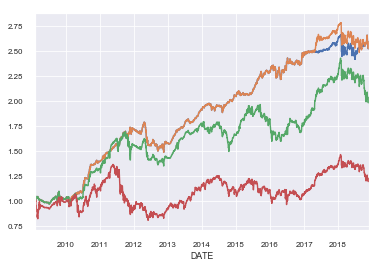

In [21]:
(preds['returns_0.0'] + 1).cumprod().plot()
(preds['returns_0.3'] + 1).cumprod().plot()
(preds['returns_0.5'] + 1).cumprod().plot()
(preds['returns_0.7'] + 1).cumprod().plot()

In [22]:
weights = utils.reverse_labels_to_weights(country, preds['preds'], 
                                          preds['probla'],
                                          preds['labels'],
                                          0.)
assets = utils.construct_virtual_assets(country)

## Performance Without Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,19.84,2012-04-23,2012-11-16,2013-11-08,405
1,13.35,2018-02-01,2018-12-27,NaT,NaN
2,7.45,2009-03-06,2009-07-13,2009-09-16,139
3,6.60,2009-10-21,2009-12-23,2010-05-12,146
4,5.93,2016-02-03,2016-04-22,2016-06-24,103


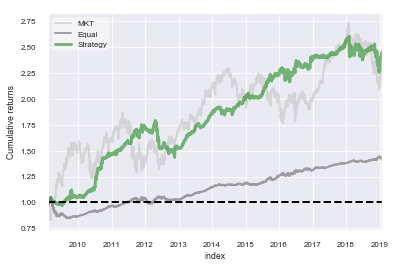

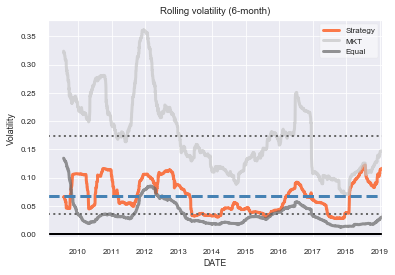

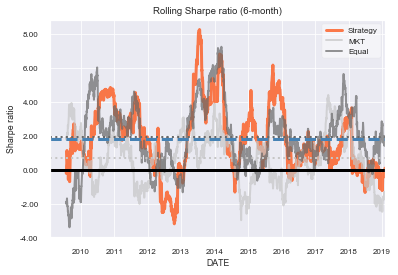

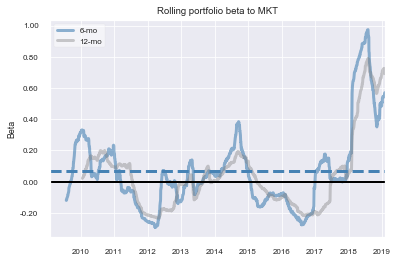

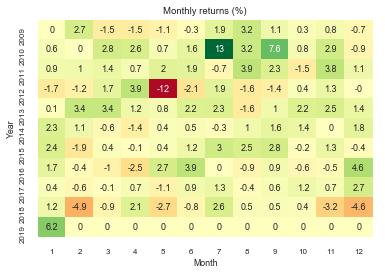

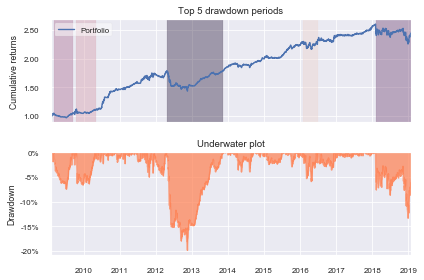

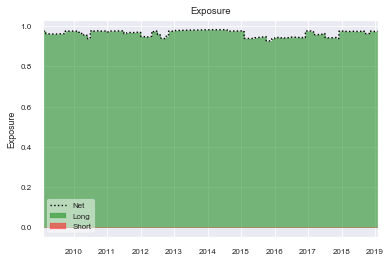

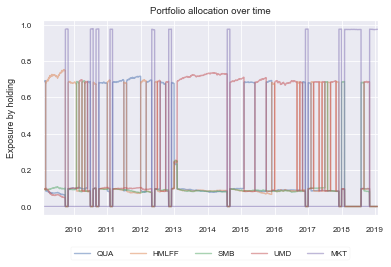

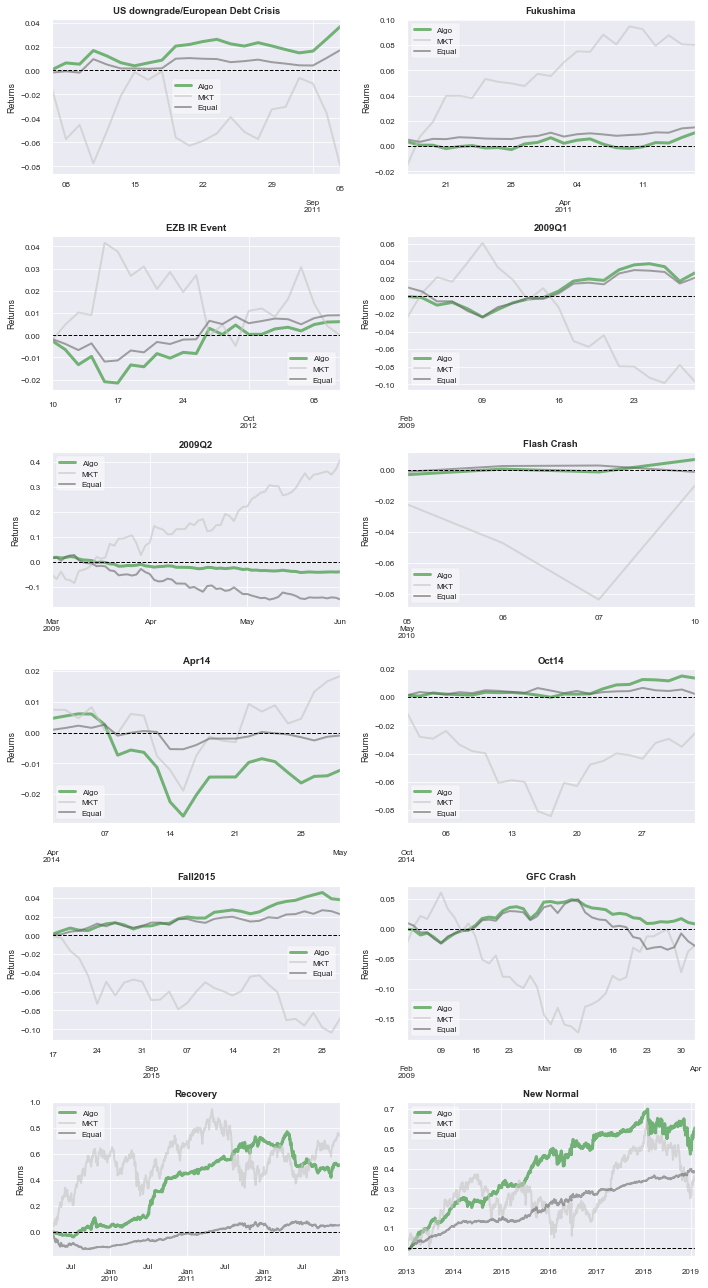

In [30]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_clean = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance With Transactions

,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.45,2012-04-23,2012-11-16,2014-02-21,480
1,16.60,2016-07-06,2018-12-27,NaT,NaN
2,7.58,2009-10-21,2010-03-02,2010-07-06,185
3,7.54,2009-03-02,2009-07-13,2009-09-16,143
4,5.93,2016-02-03,2016-04-22,2016-06-24,103


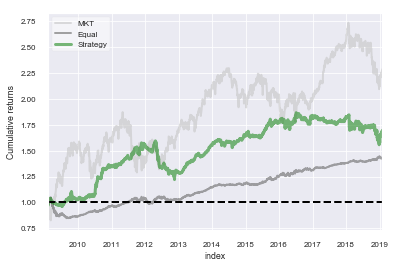

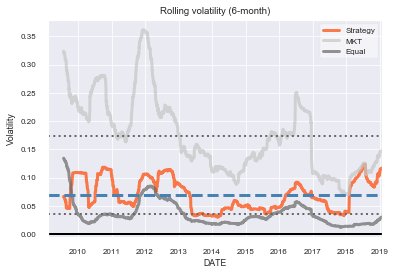

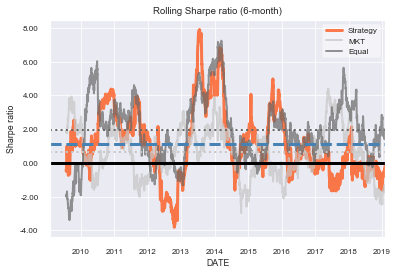

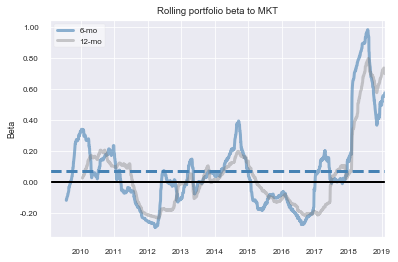

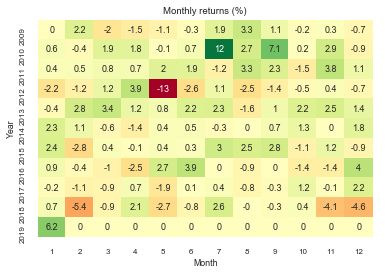

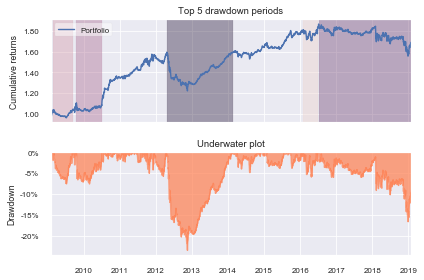

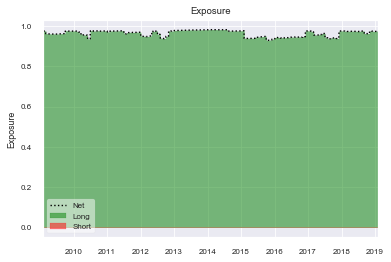

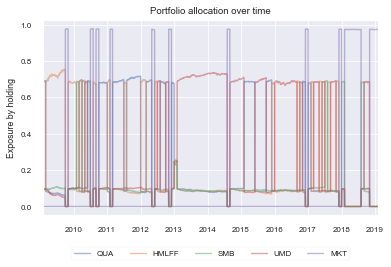

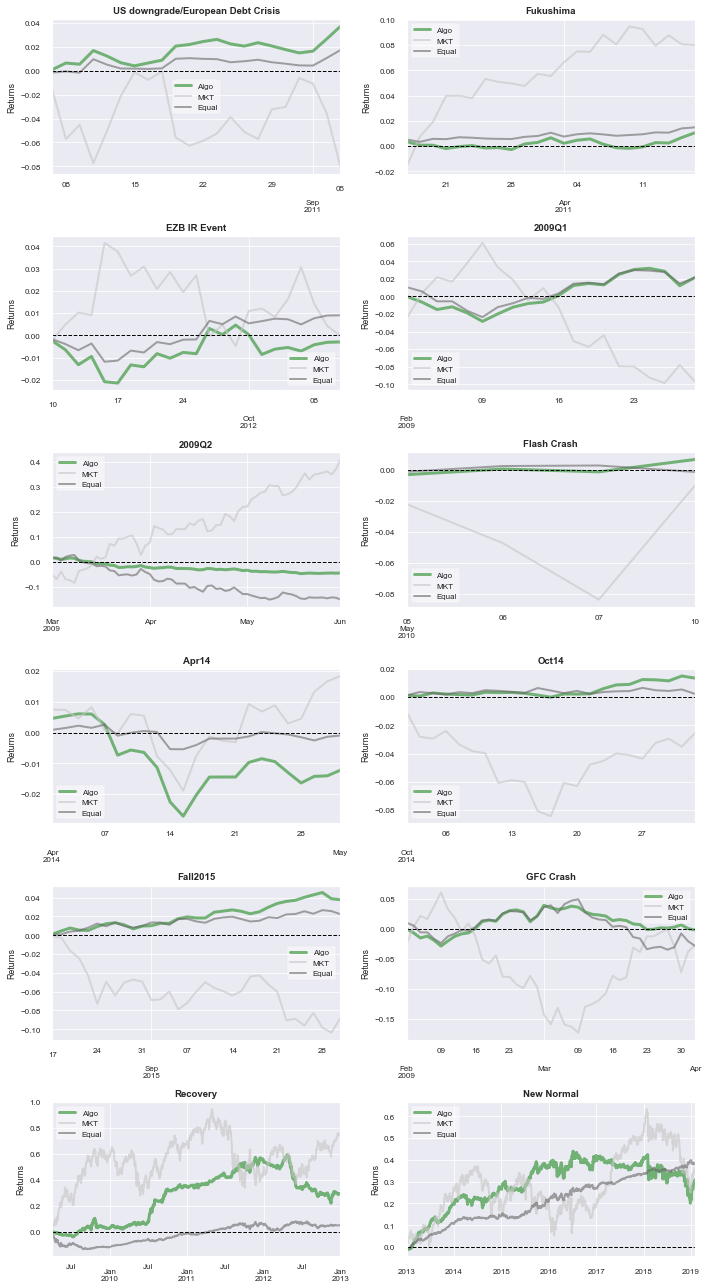

In [31]:
# Backtest with finbox
strat = finbox.backtest.build_weights_rebalance_strategy(
    tickers=['QUA', 'HMLFF', 'SMB', 'UMD', 'MKT'],
    weights=weights,
    datasets=assets,
    lazy_rebalance=True,
    is_debug=False,
    commission_settings=[
        {'commission': 0.01, 'name': 'UMD'},
        {'commission': 0.0035, 'name': 'HMLFF'},
        {'commission': 0.0035, 'name': 'SMB'},
        {'commission': 0.005, 'name': 'QUA'},
        {'commission': 0.001, 'name': 'MKT'}
    ],  # applied 0.1% transaction costs for each trade
    weight_slippage=0.025
)

benchmark1 = preds['returns_mkt']
benchmark1.name = 'MKT'
benchmark1 = benchmark1[benchmark1.index >= weights.index[0]]

benchmark2 = preds['returns_equal']
benchmark2.name = 'Equal'
benchmark2 = benchmark2[benchmark2.index >= weights.index[0]]

# Run Report Builder with matplotlib inside jupyter notebook
rb = finbox.backtest.report.ReportBuilder
rb = rb(strat, [benchmark1, benchmark2])
returns_costs = rb.returns

import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    rb.build_report(chart_type='matplotlib')

## Performance Comparison

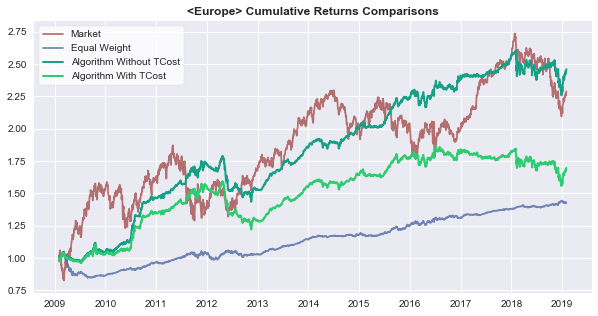

In [179]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.facecolor'] = 'w'

fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.plot((benchmark1 + 1).cumprod(), label='Market', color=utils.COLOR_MAPPER['MKT'], alpha=.85)
ax.plot((benchmark2 + 1).cumprod(), label='Equal Weight', alpha=.85, color=utils.COLOR_MAPPER['equal'])
ax.plot((returns_clean + 1).cumprod(), label='Algorithm Without TCost', color='#16A085', lw=2)
ax.plot((returns_costs + 1).cumprod(), label='Algorithm With TCost', color='#2ECC71', lw=2)
ax.set_title('<%s> Cumulative Returns Comparisons' % country, fontsize=12, fontweight=700)

ax.legend()
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots',
                                         'ML_Others', '%s_oos_perf.pdf' % country)), bbox_inches='tight')

## Feature Importances

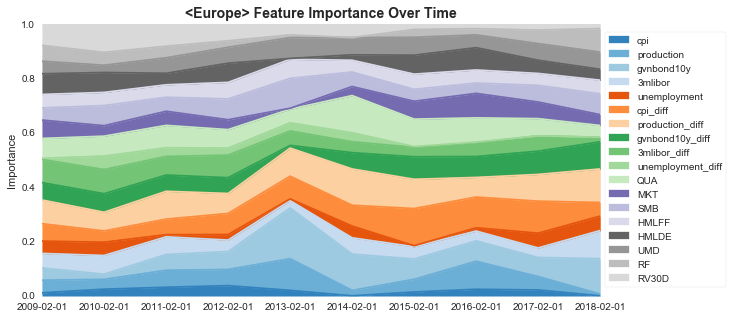

In [181]:
fig, ax = plt.subplots(1,1,figsize=(10, 5))
ax.set_title('<%s> Feature Importance Over Time' % country,
             fontsize=14, fontweight=700)
utils.plot_feature_importance_over_time(preds['models'],
                                        utils.FeatureBuilder().get_features().columns.tolist(),
                                        ax)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_importance.pdf' % country)), bbox_inches='tight')

## Weights Shifts

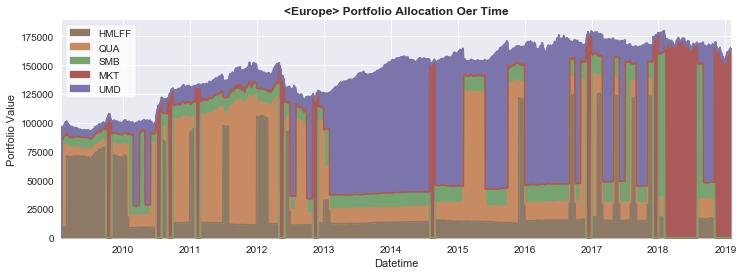

In [180]:
factors = ['HMLFF', 'QUA', 'SMB', 'MKT', 'UMD']
colors=[utils.COLOR_MAPPER[factor] for factor in factors]
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    ax = rb.positions[factors].plot.area(figsize=(12, 4), color=colors)
    ax.set_ylabel('Portfolio Value')
    ax.set_title('<%s> Portfolio Allocation Oer Time' % country,
             fontsize=12, fontweight=700)

plt.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_weights.pdf' % country)), bbox_inches='tight')

## Prediction Confusion Matrix

In [164]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          ax=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [143]:
aqr = utils.load_aqr_data(country).dropna()
portfolios = utils.build_portfolio(aqr, main_weights=[0.7],
                                   prefix_names=['main'],
                                   include_mkt=True)
rf = aqr['RF'].dropna()
mkt = aqr['MKT'].dropna()
po = utils.PortfolioOptimizer(portfolios=portfolios,
                              riskfree=rf,
                              market=mkt,
                              country=country)

po.get_stats_table()
po.get_best_indicators()

y_true, true_labels = po.get_labels()

# y_pred = preds['preds'].dropna().astype(int).values.flatten()
# y_true = y_true.loc[preds['preds'].dropna().index].astype(int).values.flatten()

y_pred = preds['preds'].dropna()
y_true = y_true.loc[y_pred.index]
for i, label in enumerate(true_labels):
    y_pred = y_pred.replace(i, label)
    y_true = y_true.replace(i, label)

Normalized confusion matrix
[[0.18518519 0.03703704 0.25925926 0.22222222 0.03703704 0.25925926]
 [0.11111111 0.         0.11111111 0.         0.22222222 0.55555556]
 [0.0625     0.         0.25       0.1875     0.         0.5       ]
 [0.14285714 0.         0.14285714 0.28571429 0.04761905 0.38095238]
 [0.         0.         0.25       0.25       0.         0.5       ]
 [0.16216216 0.         0.13513514 0.27027027 0.02702703 0.40540541]]


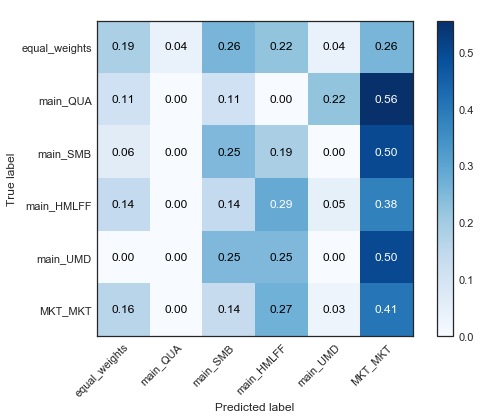

In [173]:
import matplotlib as mpl
mpl.style.use('seaborn-white')

fig, ax = plt.subplots(1,1,figsize=(8,6))
plot_confusion_matrix(y_true, y_pred, classes=true_labels, normalize=True, title=' ', ax=ax)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_cm.pdf' % country)), bbox_inches='tight')

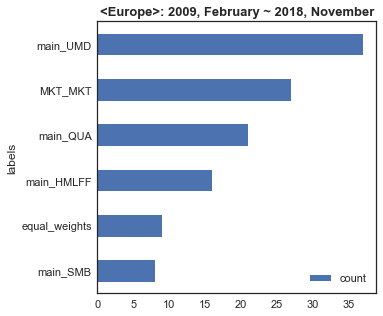

In [175]:
y_true['count'] = 1
fig, ax = plt.subplots(1,1,figsize=(5,5))
y_true.groupby('labels').sum().sort_values(by='count').plot.barh(ax=ax)
ax.set_title('<%s>: %s ~ %s' % (country, y_true.index[0].strftime('%Y, %B'),
                                y_true.index[-1].strftime('%Y, %B')), fontweight=700, fontsize=13)
fig.savefig(os.path.abspath(os.path.join(os.getcwd(), '..', 'Plots', 'ML_Others', '%s_oos_dist.pdf' % country)), bbox_inches='tight')

In [183]:
print(preds['labels'])
preds['preds'][preds['preds'].index >= '2012-07-01']

['equal_weights', 'main_QUA', 'main_SMB', 'main_HMLFF', 'main_UMD', 'MKT_MKT']


,labels
DATE,
2012-07-01,4.0
2012-08-01,1.0
2012-09-01,1.0
2012-10-01,4.0
2012-11-01,5.0
2012-12-01,1.0
2013-01-01,0.0
2013-02-01,4.0
2013-03-01,4.0


In [187]:
y_true[y_true.index >= '2012-07-01']

,labels,count
DATE,,
2012-07-01,main_UMD,1
2012-08-01,MKT_MKT,1
2012-09-01,MKT_MKT,1
2012-10-01,main_UMD,1
2012-11-01,main_UMD,1
2012-12-01,main_HMLFF,1
2013-01-01,MKT_MKT,1
2013-02-01,main_UMD,1
2013-03-01,main_UMD,1
